In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
PAIRS = ['ETH_BTC', 'ETH_USDT', 'BTC_USDT', 'ETH_USD', 'BTC_USD']
DATA_FOLDER_PREFIX = 'data_'
DECAY_DF_FOLDER = 'hawkes_best_decays'
DECAY_DF_PREFIX = 'hawkes_decay_'
DECAY_DF_SUFFIX = 'min.tsv'
HAWKES_MINUTES_TRAINING = [5,10,15,20]

In [3]:
def get_hawkes_decay_file(data_folder_prefix, pair, minutes, decay_df_folder, decay_df_prefix, decay_df_suffix):
    return os.path.join(f'{data_folder_prefix}{pair}', decay_df_folder,f'{decay_df_prefix}{minutes}{decay_df_suffix}')

def get_decays_for_df(data_folder_prefix, pair, minutes, decay_df_folder, decay_df_prefix, decay_df_suffix):
    df = pd.read_csv(get_hawkes_decay_file(data_folder_prefix, pair, minutes, decay_df_folder, decay_df_prefix, decay_df_suffix), sep='\t')
    return df['decay'].to_list()

def get_decays_for_pair(data_folder_prefix, pair, decay_df_folder, decay_df_prefix, decay_df_suffix, minutes):
    decays = {}
    for minute in minutes:
        decays[minute] = get_decays_for_df(data_folder_prefix, pair, minute, decay_df_folder, decay_df_prefix, decay_df_suffix)
    return decays

def get_decays_for_all_pairs(data_folder_prefix, pairs, decay_df_folder, decay_df_prefix, decay_df_suffix, minutes):
    decays = {}
    for pair in pairs:
        decays[pair] = get_decays_for_pair(data_folder_prefix, pair, decay_df_folder, decay_df_prefix, decay_df_suffix, minutes)
    return decays

def get_converted_decays_map_to_df(decays_map):
    decays = []
    for pair in decays_map.keys():
        for minute in decays_map[pair].keys():
            for decay in decays_map[pair][minute]:
                decays.append({'pair': pair, 'minute': minute, 'decay': decay})
    return pd.DataFrame(decays)

In [4]:
decay_map = get_decays_for_all_pairs(DATA_FOLDER_PREFIX, PAIRS, DECAY_DF_FOLDER, DECAY_DF_PREFIX, DECAY_DF_SUFFIX, HAWKES_MINUTES_TRAINING)
decay_df = get_converted_decays_map_to_df(decay_map)
decay_df['is_saturated'] = decay_df['decay'] > 99
decay_df.head()

,pair,minute,decay,is_saturated
0,ETH_BTC,5,0.343411,False
1,ETH_BTC,5,100.000000,True
2,ETH_BTC,5,100.000000,True
3,ETH_BTC,5,100.000000,True
4,ETH_BTC,5,100.000000,True


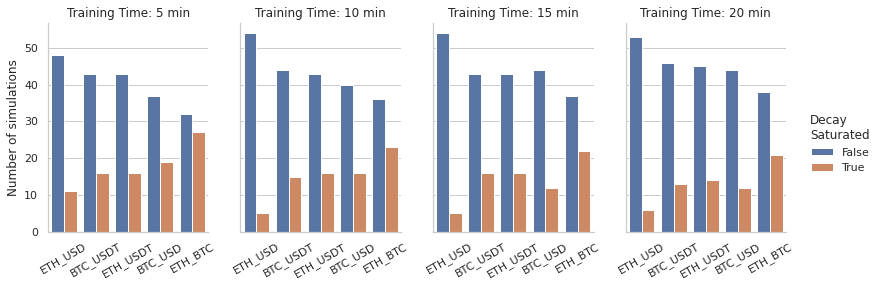

In [5]:
decay_counts_df = decay_df.groupby(['pair', 'minute', 'is_saturated']).size().reset_index(name='counts')

sns.set_theme(style="whitegrid")
g = sns.catplot(x="pair", y="counts", hue="is_saturated", col="minute", data=decay_counts_df, kind="bar", height=4, aspect=.7, order=[
    'ETH_USD', 'BTC_USDT', 'ETH_USDT', 'BTC_USD', 'ETH_BTC'
])
g.set_axis_labels("", "Number of simulations")
g.set_titles("Training Time: {col_name} min")
g.set_xticklabels(rotation=30)

# modify legend title
new_title = 'Decay\nSaturated'
g._legend.set_title(new_title)

plt.show()

# save plot in svg
g.savefig('hawkes_decays_saturated.svg')
# save plot in pdf
g.savefig('hawkes_decays_saturated.pdf')

In [35]:
def get_all_minutes_decay_df(data_folder_prefix, pair, decay_df_folder, decay_df_prefix, decay_df_suffix, minutes):
    all_minutes_decays = []
    for minute in minutes:
        df = pd.read_csv(
            get_hawkes_decay_file(data_folder_prefix, pair, minute, decay_df_folder, decay_df_prefix, decay_df_suffix),
            sep='\t'
        )

        df['Training Minutes'] = minute
        df['is_saturated'] = df['decay'] > 99
        all_minutes_decays.append(df)
        
    return pd.concat(all_minutes_decays)

In [36]:
df = get_all_minutes_decay_df(DATA_FOLDER_PREFIX, 'BTC_USD', DECAY_DF_FOLDER, DECAY_DF_PREFIX, DECAY_DF_SUFFIX, HAWKES_MINUTES_TRAINING)
df = df.reset_index(drop=True)
df.head()

,timestamp,timestamp_density,baseline,alpha,decay,Training Minutes,is_saturated
0,1705074061033,1705072791,1.588214,0.134958,100.000000,5,True
1,1705076796365,1705076144,2.076848,0.102341,100.000000,5,True
2,1705164940479,1705163925,0.212149,0.744283,0.710163,5,False
3,1705168243495,1705167726,0.131226,0.787210,0.643481,5,False
4,1705180936343,1705180536,0.238989,0.669581,0.476776,5,False


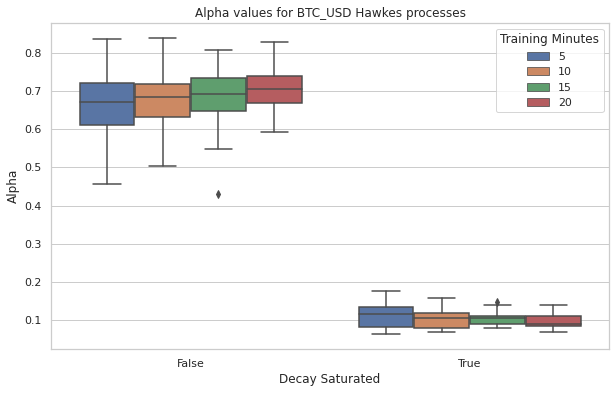

In [37]:
# plot alpha boxplot for BTC_USD divided in saturated and not saturated
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.boxplot(x='is_saturated', y='alpha', data=df, hue='Training Minutes')
plt.xlabel('Decay Saturated')
plt.ylabel('Alpha')
plt.title('Alpha values for BTC_USD Hawkes processes')

plt.show()


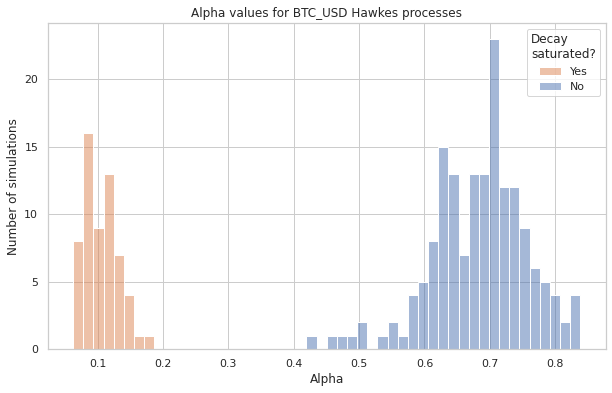

In [31]:
# histogram for alpha values
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.histplot(df, x='alpha', hue='is_saturated', bins=50)
plt.xlabel('Alpha')
plt.ylabel('Number of simulations')
plt.title('Alpha values for BTC_USD Hawkes processes')

# modify legend title
new_title = 'Decay\nsaturated?'
plt.legend(title=new_title, labels=['Yes', 'No'])

plt.show()